## Eksperimen dengan Stock Market data

In [2]:
# import libraries

from src.Model import Model
from src.Dense import Dense
from src.LSTM import LSTM
from src.Scaler import Scaler

import numpy as np
import pandas as pd

In [3]:
# Load and tampilkan sebagian data

df_train = pd.read_csv('./Dataset/StockMarket/Train_stock_market.csv')
df_train.index = pd.to_datetime(df_train['Date'], format='%d-%m-%Y')
df_train

,Date,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,,
1984-09-07,07-09-1984,5.25,5.500,7900,5.50,5.25,5.25
1984-09-10,10-09-1984,5.25,5.250,600,5.50,5.25,5.25
1984-09-11,11-09-1984,5.25,5.250,3500,5.50,5.25,5.25
1984-09-12,12-09-1984,5.50,5.500,700,5.50,5.50,5.50
1984-09-13,13-09-1984,5.00,5.500,1700,5.50,5.00,5.00
...,...,...,...,...,...,...,...
2022-12-06,06-12-2022,3.76,3.800,22400,3.99,3.81,3.81
2022-12-07,07-12-2022,3.68,3.750,18000,3.85,3.74,3.74
2022-12-08,08-12-2022,3.80,3.820,51600,4.00,3.85,3.85


In [4]:
# Fungsi untuk preprocessing data time series

# Mengubah pandas DataFrame ke numpy array, hanya mengambil kolom-kolom tertentu (parameter columns)
def df_to_np(df, columns):
  return df[columns].to_numpy()

# Membuat sequences, data bertipe numpy array
def create_sequences(data, seq_length):
  sequences = []
  targets = []
  data_len = len(data)
  for i in range(data_len - seq_length):
    seq_end = i + seq_length
    seq_x = data[i:seq_end]
    seq_y = data[seq_end]
    sequences.append(seq_x)
    targets.append(seq_y)

  return np.array(sequences), np.array(targets)

In [5]:
# Preprocess data

columns = ['Low', 'Open', 'Volume', 'High', 'Close']
train_np = df_to_np(df_train, columns)

scaler = Scaler()
scaler.fit(train_np)
train_np_scaled = scaler.transform(train_np)

X_train, y_train = create_sequences(train_np_scaled, 5)
X_train.shape, y_train.shape

((9640, 5, 5), (9640, 5))

In [6]:
# Load model

model = Model.load_model('./Models/model_4_parameters.json')
model.summary()

Model: "sequential"
_______________________________________________________
Layer (type)        Output Shape        Param #        
lstm (LSTM)         (None, 64)          17920          
dense (Dense)       (None, 5)           325            
Total params: 18245


In [7]:
# Melakukan prediksi

predictions = model.predict(X_train)
predictions_inversed = scaler.inverse_transform(predictions)

AttributeError: Line2D.set() got an unexpected keyword argument 'columns'

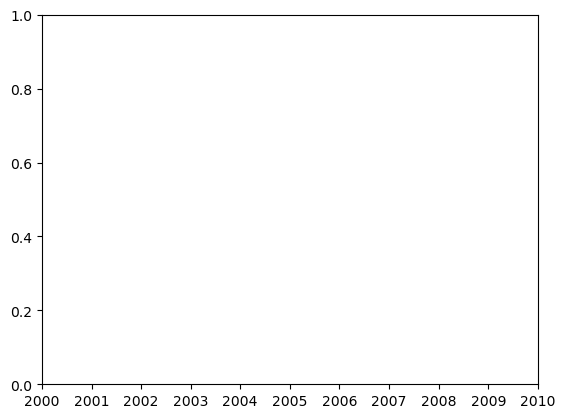

In [10]:
import matplotlib.pyplot as plt

date_seq = create_sequences(df_to_np(df_train, ['Date']), 5)
date = date_seq[1][:, 0]

results_dict = { 'Date': date }
for i in range(len(columns)):
  if columns[i] == 'Volume':
    continue

  results_dict[columns[i]] = predictions_inversed[:, i]

results = pd.DataFrame(data=results_dict)
results.index = pd.to_datetime(results['Date'], format='%d-%m-%Y')
results.plot()

In [9]:
t = np.array([[1, 2], [3, 1]])
t - t.min(axis=0)

array([[0, 1],
       [2, 0]])